# Artificial Neural Networks

## Classification

### Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random
random.seed(42)
np.random.seed(42)

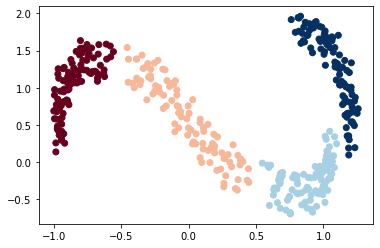

In [3]:
import math
N = 400
NC = 100
X = np.array([(np.cos(math.pi + 1*(i/NC)) - i/(NC*10) + (np.random.rand()*0.1) + 0.16*math.floor(i/NC),
               np.sin(math.pi + -2*(i/NC)) + i/(NC*10) + (np.random.rand()*0.6)) for i in range(N)])
Y = np.array([math.floor(i/NC) for i in range(N)])
plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.RdBu)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=42)

In [5]:
print(x_train.shape)
print(x_test.shape)

(300, 2)
(100, 2)


### Scikit-Learn

In [6]:
from sklearn.neural_network import MLPClassifier
ann = MLPClassifier(random_state=42, max_iter=1000)
ann.fit(x_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

In [7]:
print(ann.activation, ann.learning_rate, ann.hidden_layer_sizes)

relu constant (100,)


In [8]:
predicted = ann.predict(x_test)

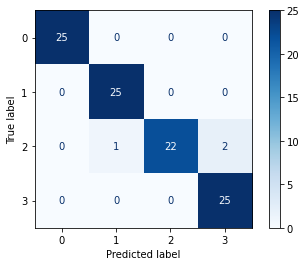

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted, labels=[0,1,2,3])
c = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
c.plot(cmap=plt.cm.Blues)

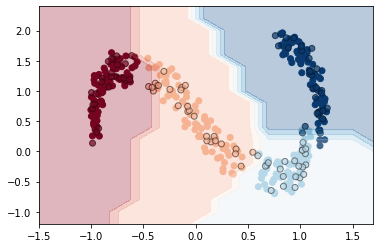

In [10]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.RdBu, alpha=1)
plt.scatter(x_test[:, 0], x_test[:, 1], c=predicted, cmap=plt.cm.RdBu, alpha=0.7,
            edgecolors='k')
Z = ann.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.3)

### PyTorch

In [13]:
import torch
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
x_train_t = torch.from_numpy(x_train).to(device)
x_test_t= torch.from_numpy(x_test).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
y_test_t = torch.from_numpy(y_test)

In [15]:
input_size = x_train_t.shape[1]
hidden_layer_size = 100
output_size = 4
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, output_size)
)
model.double().to(device)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=4, bias=True)
)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
for i in range(1000):
    y_pred_t = model(x_train_t)
    loss = criterion(y_pred_t, y_train_t)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (i, loss.item()), end='\r')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

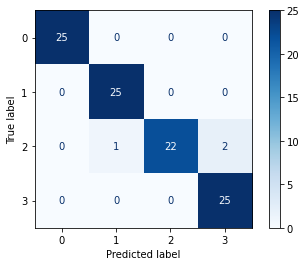

In [18]:
predicted = model(x_test_t).cpu().max(1).indices
cm = confusion_matrix(y_test, predicted, labels=[0,1,2,3])
c = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
c.plot(cmap=plt.cm.Blues)

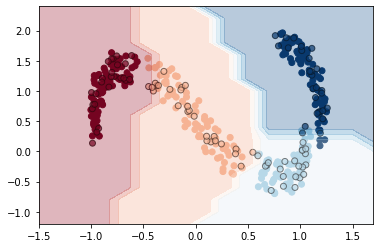

In [19]:
model.cpu()
x_train_t = x_train_t.cpu()
x_test_t = x_test_t.cpu()
y_train_t = y_train_t.cpu()

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))
plt.scatter(x_train_t[:, 0], x_train_t[:, 1], c=y_train_t, cmap=plt.cm.RdBu, alpha=1)
plt.scatter(x_test_t[:, 0], x_test_t[:, 1], c=predicted, cmap=plt.cm.RdBu, alpha=0.7,
            edgecolors='k')
with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).double()
    Z = model(data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.3)

## Regression

### Data

torch.Size([1000, 1]) torch.Size([1000, 1])


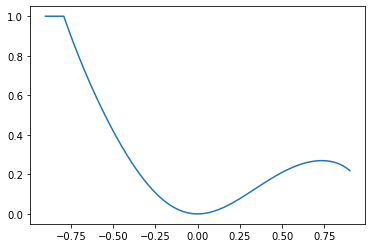

In [20]:
def f_target(x):
    return torch.max(torch.min((torch.acos(x) * x.pow(2) / (1+torch.tanh(x**2))),
                               torch.scalar_tensor(1)),
                     torch.scalar_tensor(0))
X = torch.unsqueeze(torch.linspace(-0.9, 0.9, 1000), dim=1) 
y = f_target(X)
print(X.shape, y.shape)
plt.plot(X, y)

### Scikit-Learn

In [21]:
from sklearn.neural_network import MLPRegressor
ann = MLPRegressor(max_iter=1000, hidden_layer_sizes=5000)
ann.fit(X, y.reshape(-1))
y_pred = ann.predict(X)

In [22]:
print(ann.activation, ann.learning_rate, ann.hidden_layer_sizes)

relu constant 5000


(-1.0, 1.0, 0.0, 1.0)

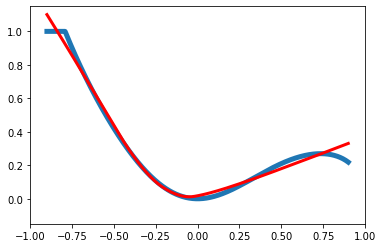

In [23]:
plt.plot(X, y, lw=5)
plt.plot(X, y_pred, c='red', lw=3)
plt.axis('equal')
plt.axis(np.array((-1, 1, 0, 1)))

### PyTorch

In [24]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
input_size = 1
hidden_layer_size = 100
output_size = 1
model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_size, output_size)
)
model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [25]:
criterion = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
X = X.to(device)
y = y.to(device)
for i in range(1000):
    y_pred = model(X)
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (i, loss.item()), end='\r')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

(-1.0, 1.0, 0.0, 1.0)

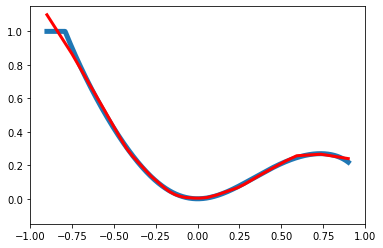

In [27]:
plt.plot(X.cpu().detach(), y.cpu().detach(), lw=5)
plt.plot(X.cpu().detach(), y_pred.cpu().detach(), c='red', lw=3)
plt.axis('equal')
plt.axis(np.array((-1, 1, 0, 1)))